## Simulation

In [1]:
from tadawol.history import get_top_tickers
from tadawol.strategies import macd
from tadawol.strategies import earnings
from tadawol.strategies import reverse

top_tickers = get_top_tickers(0, 500)
strategy = macd.MACD()
data = strategy.simulate(top_tickers)
print("Entries number = ", data.shape)

2020-10-26 13:21:28,203 tadawol.history INFO     Historical data is extracted, rows_umber = 670266
2020-10-26 13:21:28,288 tadawol.strategies.base_strategy INFO     Simulating strategy for 495 tickers
2020-10-26 13:21:39,084 tadawol.strategies.base_strategy INFO     Simulation in progress : 4%
2020-10-26 13:21:49,795 tadawol.strategies.base_strategy INFO     Simulation in progress : 8%
2020-10-26 13:22:01,847 tadawol.strategies.base_strategy INFO     Simulation in progress : 12%
2020-10-26 13:22:13,248 tadawol.strategies.base_strategy INFO     Simulation in progress : 16%
2020-10-26 13:22:24,334 tadawol.strategies.base_strategy INFO     Simulation in progress : 20%
2020-10-26 13:22:35,893 tadawol.strategies.base_strategy INFO     Simulation in progress : 24%
2020-10-26 13:22:46,845 tadawol.strategies.base_strategy INFO     Simulation in progress : 28%
2020-10-26 13:22:57,116 tadawol.strategies.base_strategy INFO     Simulation in progress : 32%
2020-10-26 13:23:08,318 tadawol.strategie

Entries number =  (26322, 99)


## Add companies general data

In [2]:
# JOIN RESULTS WITH TICKERS DATA
import pandas as pd
from math import log


from tadawol import history

tickers_data = pd.read_csv(history.TICKERS_LIST_PATH)

data = pd.merge(tickers_data, data, on="Ticker", how="inner")
data.rename(columns={"Volume_y": "Volume"}, inplace=True)


## Get earnings

In [3]:
from tadawol.earnings import get_earnings_data_on_all_dates

earnings_by_date = get_earnings_data_on_all_dates(data)
data_with_earnings = pd.merge(data, earnings_by_date, on=["Ticker", "Date"])

print("SHAPES RATIO = ", round(data_with_earnings.shape[0]/data.shape[0], 2))


2020-10-26 13:26:12,322 tadawol.earnings INFO     Tickers number = 472
2020-10-26 13:26:27,284 tadawol.earnings INFO     [Earnings] Treated tickers number = 21%
2020-10-26 13:26:42,062 tadawol.earnings INFO     [Earnings] Treated tickers number = 42%
2020-10-26 13:26:57,873 tadawol.earnings INFO     [Earnings] Treated tickers number = 64%
2020-10-26 13:27:13,659 tadawol.earnings INFO     [Earnings] Treated tickers number = 85%
2020-10-26 13:27:22,938 tadawol.earnings INFO     Putting data into dataframe ...: rows number = 26190
2020-10-26 13:27:22,965 tadawol.earnings INFO     Adding features ...


SHAPES RATIO =  0.99


## Helper functions

In [4]:
def print_results_by_column(df):
    
    bad_results = df[df["win_percent"] < -3]
    good_results = df[df["win_percent"] > 3]
    
    columns = ["exit_date", "week_previous_entries"]
    
    for column in columns:
        print(f"***** {column} *****")
        print("Bad result : ", round(bad_results[column].mean(), 2))
        print("Good result : ", round(good_results[column].mean(), 2))


In [5]:
import pandas as pd
import statistics 
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from prettytable import PrettyTable

from tadawol.simulator import simulate_trades

def _performance_by(df, column, index):
    
    x = []
    labels = []
    occurences = []
    win_percents = []
    i = 1
    for column_value, column_data in df.groupby([column]):
        labels.append(column_value)
        x.append(i)
        occurences.append(column_data.shape[0])
        win_percent = column_data["win_percent"].mean()
        win_percents.append(win_percent)
        i += 1
    
    f = plt.figure(index)
    plt.plot(x, occurences)
    plt.plot(x, len(x)* [statistics.mean(occurences)])
    plt.xticks(x, labels, rotation='vertical')
    f.show()
    
    index += 1
    g = plt.figure(index)
    plt.plot(x, win_percents)
    plt.plot(x, len(x)* [0])
    plt.xticks(x, labels, rotation='vertical')
    g.show()

    


def plot_trades(trades_df, plot_index):
    
    months = []
    win_percents = []
    
    trades_df["month"] = trades_df["Date"].map(lambda x: datetime(x.year, x.month, 1))
    
    for month, month_trades in trades_df.groupby(["month"]):
        trades_product = 1
        months.append(month)
        win_percents.append( month_trades["win_percent"].mean())
        
    f = plt.figure(plot_index)
    x = range(1, len(months) + 1)
    plt.plot(x, win_percents)
    plt.plot(x, len(win_percents) * [0])
    plt.xticks(x, months, rotation='vertical')
    f.show()
    
def analyse_results(df: pd.DataFrame, print_figures: bool = True, total_amount=30000, transaction_min=1500, transaction_max=2200, max_trades_by_day=4) -> None:
    df = df.copy(deep=True)
    min_date = df["Date"].min()
    max_date = df["Date"].max()
    days_number = (5.0 / 7.0) * (max_date - min_date).total_seconds() / (60 * 60 * 24) + 1
    win, trade_fees, realized_trades_df = simulate_trades(df, total_amount, transaction_min, transaction_max, max_trades_by_day)
    
    
    x = PrettyTable()
    x.field_names = ["KPI", "value"]

    x.add_row(["Enter cases number", df.shape[0]])
    x.add_row(["Cases number per day", round(df.shape[0]/days_number, 2)])
    x.add_row(["Average winning cases", round(100 * df[df["win_percent"] >= 0].shape[0] / df.shape[0], 1)])
    x.add_row(["Average win", round(df["win_percent"].mean(), 2)])
    x.add_row([f"New account for {round(total_amount/1000)} K€", round(win)])
    x.add_row(["Trade fees", trade_fees])
    x.add_row(["Trade number", realized_trades_df.shape[0]])
    x.add_row(["Total margin", round(100 * (win - trade_fees)/total_amount, 1)])
    print(x)
    df.loc[:, "win_percent"] = df["win_percent"].astype(float)
    df[["win_percent"]].hist(bins=50)
    
    plot_trades(realized_trades_df, 2)
    
    if not print_figures:
        return None
    
        
    df.loc[:, "month"] = df['Date'].map(lambda x: f"{x.month}/{x.year}")
    
    
    index = 3
    labels = ["month", "Country", "Sector", "week_previous_entries"]
    for label in labels:
        _performance_by(df, label, index)
        index += 2
        
    return None


def print_cases(df: pd.DataFrame, bad=True, start=0, end=10):
    
    df = df.copy(deep=True)
    ascending = True
    if not bad:
        ascending = False
    df.sort_values(by=["win_percent", "Date"], ascending=ascending, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    columns = [
        "Ticker", "Date", "win_percent", "company_short_name", 
        "Country", "Sector", "days_to_next_result", "days_since_last_result","exit_date", 
        "Close", "Open", "exit_price"]
    df = df[columns]
    df = df.loc[start:end]
    return df
    

+-----------------------+-------+
|          KPI          | value |
+-----------------------+-------+
|   Enter cases number  |  7156 |
|  Cases number per day |  7.42 |
| Average winning cases |  62.8 |
|      Average win      |  1.84 |
| New account for 30 K€ | 85069 |
|       Trade fees      |  3134 |
|      Trade number     |  1567 |
|      Total margin     | 273.1 |
+-----------------------+-------+


/Users/yassineameur/.virtualenvs/tadawol/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/yassineameur/.virtualenvs/tadawol/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/yassineameur/.virtualenvs/tadawol/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


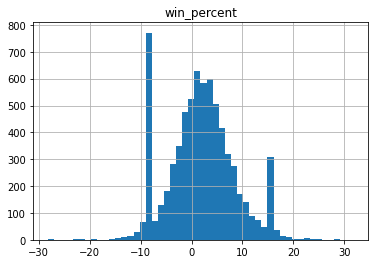

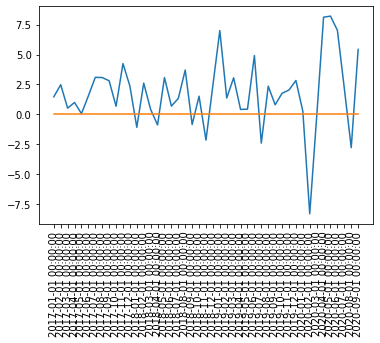

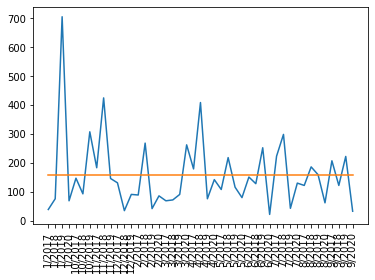

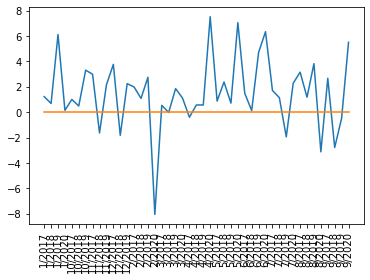

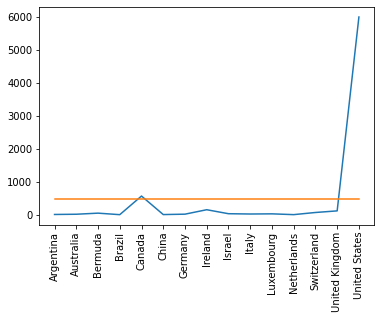

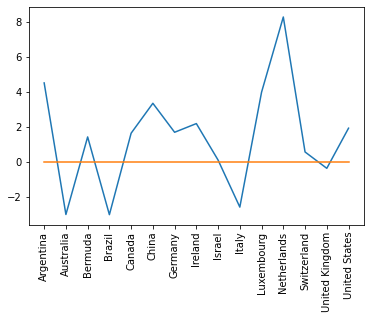

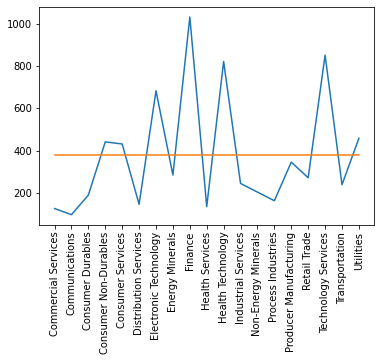

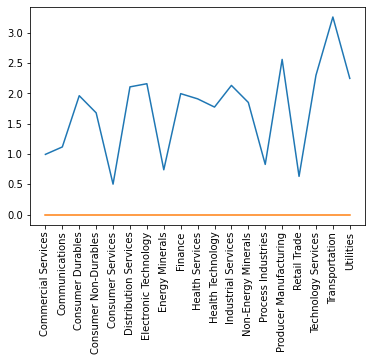

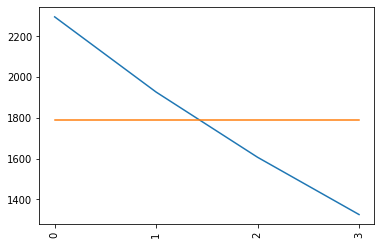

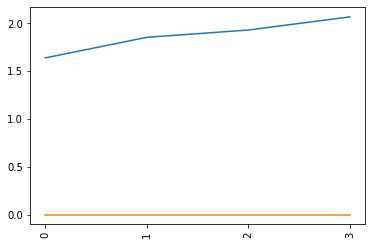

In [6]:
trades = analyse_results(data_with_earnings, print_figures=True, max_trades_by_day=3)

+-----------------------+-------+
|          KPI          | value |
+-----------------------+-------+
|   Enter cases number  |  4168 |
|  Cases number per day |  4.56 |
| Average winning cases |  62.9 |
|      Average win      |  1.97 |
| New account for 30 K€ | 62547 |
|       Trade fees      |  2074 |
|      Trade number     |  1037 |
|      Total margin     | 201.6 |
+-----------------------+-------+


/Users/yassineameur/.virtualenvs/tadawol/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


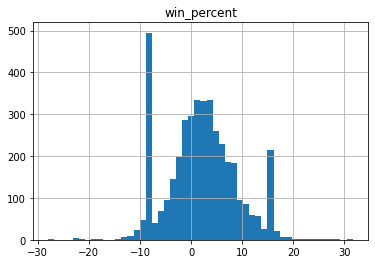

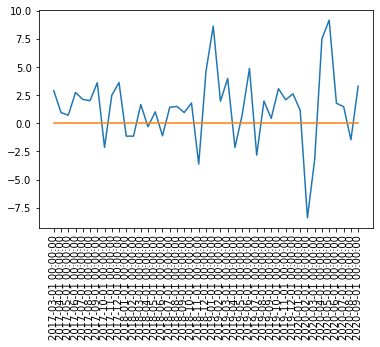

In [8]:
df = data_with_earnings[(data_with_earnings["sma_decreasing"])]
analyse_results(df, print_figures=False, max_trades_by_day=3)


In [10]:
print_cases(df, False, 30, 50)

,Ticker,Date,win_percent,company_short_name,Country,Sector,days_to_next_result,days_since_last_result,exit_date,Close,Open,exit_price
30,PINS,2020-04-01,16.9372,"Pinterest, Inc.",United States,Technology Services,34,55,5,14.170000,14.600000,16.57
31,AJG,2020-05-06,16.9173,Arthur J. Gallagher & Co.,United States,Finance,85,6,14,80.449997,84.160004,94.06
32,TWTR,2017-04-25,16.9168,"Twitter, Inc.",United States,Technology Services,1,75,4,14.660000,14.710000,17.14
33,CINF,2020-05-28,16.807,Cincinnati Financial Corporation,United States,Finance,218,31,7,60.570000,62.000000,70.75
34,MT,2019-09-04,16.6892,ArcelorMittal,Luxembourg,Non-Energy Minerals,155,34,7,14.800000,14.610000,17.27
35,CQP,2020-04-02,16.6845,"Cheniere Energy Partners, L.P.",United States,Industrial Services,28,37,14,27.990000,25.809999,32.66
36,SIVB,2019-01-07,16.5626,SVB Financial Group,United States,Finance,17,74,13,205.039993,201.720001,239
37,SBUX,2020-03-31,16.5501,Starbucks Corporation,United States,Consumer Services,28,63,12,65.739998,67.180000,76.62
38,CAT,2020-03-27,16.5497,Caterpillar Inc.,United States,Producer Manufacturing,32,56,7,105.440002,104.430000,122.89
39,TWTR,2017-04-24,16.5194,"Twitter, Inc.",United States,Technology Services,2,74,5,14.710000,14.700000,17.14


In [ ]:
data_with_earnings[data_with_earnings["Ticker"] == "TJX"]

### Clean data

In [ ]:
import numpy as np
from datetime import datetime

# Avoid coronavirus period
cleaned_data = data_with_earnings[data_with_earnings["Date"] < datetime(2020, 1, 1)] 
# Avoid 2018 little crisis
cleaned_data = cleaned_data[(cleaned_data["Date"] < datetime(2018, 11, 1)) | (cleaned_data["Date"] > datetime(2018, 12, 31))]

## Simulate top tickers

In [ ]:
# Take 100 top tickers
top_tickers = get_top_tickers(0, 300)
top_companies_trades = cleaned_data[cleaned_data["Ticker"].isin(top_tickers)]
analyse_results(top_companies_trades, True, max_trades_by_day=4)


In [ ]:
print_results_by_column(df)

In [ ]:
ticker = ""
ticker_trades = top_companies_trades[top_companies_trades["Ticker"] == ticker]
ticker_trades[["Ticker", "Date", "win_percent", "exit_date", "exit_reason"]]
print_results_by_column(top_companies_trades)

## LABORATORY

In [ ]:
# Try losing days

df = top_companies_trades.copy(deep=True)#[cleaned_data["Close"] < 1 * cleaned_data["Open"]]
df = df[df["Close"] > df["Open"]]
df = df[df["long_ema_evolution"]/df["Close"] > 0.002]
df = df[df["week_previous_entries"] > 0]
df = df[df["short_ema_evolution"] > 0.1]
df = df[df["earnings_surprise"] < 20]
analyse_results(df, False, total_amount=20000, max_trades_by_day=10, min_invest_per_trade=0.05)

In [ ]:
print_cases(df, False, 10, 20)

In [ ]:
df.groupby

## END LABORATORY

## Today results

In [ ]:
import pandas as pd

from tadawol.strategies import recovery
from tadawol.strategies import macd
from tadawol.history import get_top_tickers
from tadawol.earnings import get_earnings_data_on_all_dates

strategy = macd.MACD()

tickers = get_top_tickers(0, 100)
macd_today_trades, macd_today_exits = strategy.get_today_trades_and_exits(tickers)


earnings_by_date = get_earnings_data_on_all_dates(macd_today_trades)
macd_today_trades = pd.merge(macd_today_trades, earnings_by_date, on=["Ticker", "Date"])
#macd_today_trades = macd_today_trades[macd_today_trades["days_to_next_result"] > 20]
#macd_today_trades = macd_today_trades[macd_today_trades["days_since_last_result"] > 0]
macd_today_trades = macd_today_trades[macd_today_trades["week_previous_entries"] >= 1]



In [ ]:
macd_today_trades["exit"].max()
#macd_today_exits.sort_values(by=["Date"], ascending=False).head()

In [ ]:
macd_today_trades["Date"].max()

In [ ]:
columns = [
        "Date", "Ticker", "company_short_name", "Close", "week_previous_entries",
        "earnings_surprise", "days_to_next_result", "exit_reason"]

tr = today_trades[columns]

In [ ]:

from tadawol.strategies import earnings
from tadawol.strategies import macd
from tadawol.history import get_top_tickers
from tadawol.earnings import get_earnings_data_on_all_dates

strategy = macd.MACD()

tickers = get_top_tickers(0, 300)
earnings_today_trades_1, earnings_today_exits_1 = strategy.get_today_trades_and_exits(tickers)


In [ ]:
earnings_today_trades = earnings_today_trades_1[earnings_today_trades_1["week_previous_entries"] >= 1]

In [ ]:
earnings_today_trades_1

In [ ]:
columns = ["Date", "Ticker", "exit", "exit_data", "entry", "Close"]

for i in range(1, 16):
    columns.append("Close_{}".format(i))

earnings_today_trades_1[earnings_today_trades_1["week_previous_entries"] >= 1].sort_values(by="Date", ascending=False).head(50)[columns]

In [ ]:
from datetime import datetime

earnings_today_trades_1[earnings_today_trades_1["exit"] == datetime(2020, 9, 30)].head()

In [ ]:
from tadawol import earnings
earnings_df = earnings.get_earnings_df()


In [ ]:
earnings_df = earnings_df[earnings_df["ticker"] == "PGR"]
earnings_df.sort_values(by=["Date"], ascending=False, inplace=True)
earnings_df.head()

In [ ]:
from tadawol import history
import pandas as pd

history = df = pd.read_csv(history.TICKERS_LIST_PATH)

In [ ]:
history[history["Ticker"] == "PGR"]

In [ ]:
data_with_earnings["Date"].min()

In [ ]:
data_with_earnings.shape[0]